<a href="https://colab.research.google.com/github/juanigp/CT-denoising/blob/master/Training_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
!git clone -l -s git://github.com/juanigp/CT-denoising.git cloned-repo
%cd cloned-repo
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
!pip install SimpleITK
import SimpleITK as sitk
import torch.utils.data.sampler as sampler
import torch.nn as nn
import torch
import random
import os
import utils.ReadWriteXML as rw
from utils import utils
from models.EDCNN import EDCNN

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
Cloning into 'cloned-repo'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 260 (delta 126), reused 134 (delta 44), pack-reused 0
Receiving objects: 100% (260/260), 40.49 MiB | 33.68 MiB/s, done.
Resolving deltas: 100% (126/126), done.
/content/cloned-repo
     |████████████████████████████████| 42.5MB 201kB/s 


Text(0.5, 0.98, 'Loss vs epochs: 100 mAs - 250 mAs - 360 mAs')

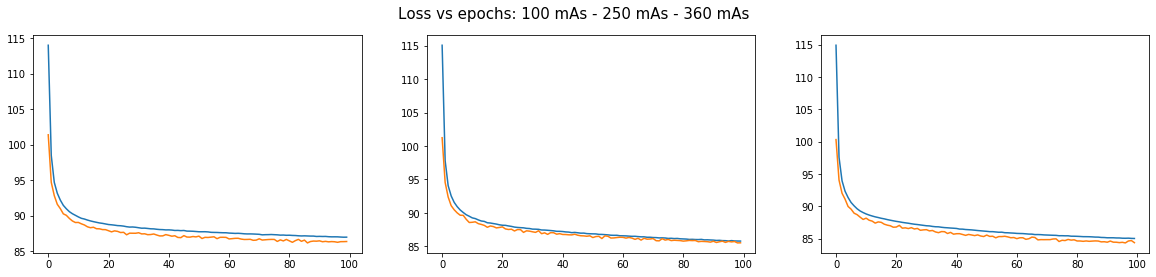

In [12]:
loss_100 = r'/gdrive/My Drive/models/training_loss.csv' 
df_100 = pd.read_csv(loss_100, names=['train loss', 'test loss'])
loss_250 = r'/gdrive/My Drive/models/training_loss_250.csv' 
df_250 = pd.read_csv(loss_250, names=['train loss', 'test loss'])
loss_360 = r'/gdrive/My Drive/models/training_loss_360.csv' 
df_360 = pd.read_csv(loss_360, names=['train loss', 'test loss'])

fig = plt.figure(figsize=(20, 4))
fig.add_subplot(1, 3, 1)
plt.plot( df_100['train loss'].values )
plt.plot( df_100['test loss'].values )
fig.add_subplot(1, 3, 2)
plt.plot( df_250['train loss'].values )
plt.plot( df_250['test loss'].values )
fig.add_subplot(1, 3, 3)
plt.plot( df_360['train loss'].values )
plt.plot( df_360['test loss'].values )
plt.suptitle('Loss vs epochs: 100 mAs - 250 mAs - 360 mAs', fontsize = 15)

### The training loss was calculated during the execution of the epochs, meanwhile the test loss was calculated after a training epoch, with fixed network parameters.

In [0]:
lr_dir = r'/gdrive/My Drive/volumes/calib'
gt_dir = r'/gdrive/My Drive/volumes/XCT'

checkpoint_100_dir = r'/gdrive/My Drive/models/EDCNN_checkpoint_epoch_100.pth.tar'
checkpoint_250_dir = r'/gdrive/My Drive/models/EDCNN_250_checkpoint_epoch_100.pth.tar'
checkpoint_360_dir = r'/gdrive/My Drive/models/EDCNN_360_checkpoint_epoch_100.pth.tar'

checkpoint_100 = torch.load(checkpoint_100_dir)
checkpoint_250 = torch.load(checkpoint_250_dir)
checkpoint_360 = torch.load(checkpoint_360_dir)

model_100 = EDCNN()
model_250 = EDCNN()
model_360 = EDCNN()

model_100.load_state_dict(checkpoint_100['model'])
model_250.load_state_dict(checkpoint_250['model'])
model_360.load_state_dict(checkpoint_360['model'])

model_100.cuda()
model_250.cuda()
model_360.cuda()

model_100.eval()
model_250.eval()
model_360.eval()

EDCNN(
  (enc_1): Sequential(
    (0): Conv3d(1, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (enc_2): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (enc_3): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (enc_4): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (dec_1): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (dec_2): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (dec_3): Sequential(
    (0): ConvTranspose3d(32, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
  )
  (dec_4): ConvTranspose3d(32, 1, kernel_size=(3, 5, 5), stride=(1, 1, 1))
)

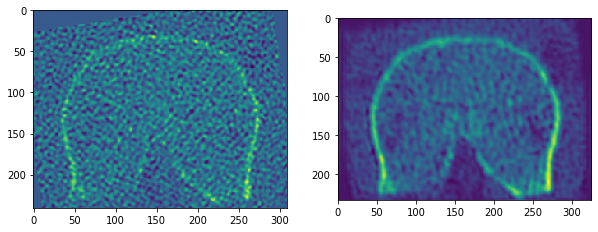

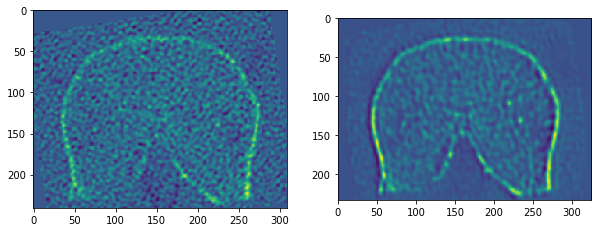

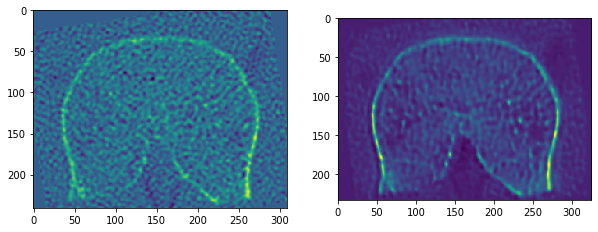

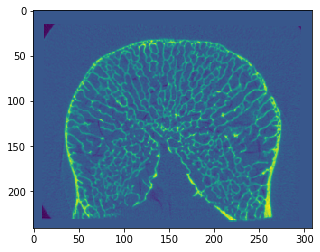

In [0]:
#opening input volume
target_volume_ = rw.OpenXML(os.path.join(gt_dir, '5a_XCTSlices.xml'), kind = 'Slices' )
target_volume = sitk.GetArrayFromImage(target_volume_)

volumes_nets = [('5a_100_FBPPhil_Scan1Slices.xml', model_100 ),
                ('5a_250_FBPPhil_Scan1Slices.xml', model_250 ),
                ('5a_360_FBPPhil_Scan1Slices.xml', model_360) ]
count = 0
for volume, model in volumes_nets:
  input_volume_ = rw.OpenXML(os.path.join(lr_dir, volume), kind = 'Slices' )
  input_volume = sitk.GetArrayFromImage(input_volume_)[46:55,:,:]

  z, x, y = input_volume.shape
  padded = np.zeros((z,x+16,y+16))
  padded[:,8:x+8, 8:y+8] = input_volume
  input_volume_tensor = torch.from_numpy(padded)
  input_volume_tensor = input_volume_tensor.unsqueeze(0).unsqueeze(0)
  input_volume_tensor = utils.var_or_cuda( input_volume_tensor )
  input_volume_tensor = input_volume_tensor.type(torch.FloatTensor).cuda()
  net_output = model(input_volume_tensor)
  output_cpu_ = net_output.detach()
  output_cpu_ = output_cpu_.cpu()
  output_cpu = output_cpu_[0][0][:][:][:]

  fig = plt.figure(count, figsize=(10, 5))
  a = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(input_volume[4][:][:])
  a = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(output_cpu[4][8:x+8][8:y+8])
  count += 1

fig = plt.figure(count, figsize=(7, 4))
imgplot = plt.imshow(target_volume[50][:][:])

In [0]:
csvs_100 = (r'/gdrive/My Drive/patches/100_FBPPhil.csv',
            r'/gdrive/My Drive/patches/100_FBPPhil_bm4d.csv')

csvs_250 = (r'/gdrive/My Drive/patches/250_FBPPhil.csv',
            r'/gdrive/My Drive/patches/250_FBPPhil_bm4d.csv')

csvs_360 = (r'/gdrive/My Drive/patches/360_FBPPhil.csv',
            r'/gdrive/My Drive/patches/360_FBPPhil_bm4d.csv')

csvs_list = [csvs_100, csvs_250, csvs_360]
dataloader_list = []
batch_size = 32
for csv_tuple in csvs_list:
  dataset_lr = utils.CTVolumesDataset( csv_tuple[0] )
  dataset_bm4d = utils.CTVolumesDataset( csv_tuple[1] )
  num_samples = len(dataset_bm4d)
  total_idx = list(range(num_samples))
  random.seed(10)
  random.shuffle(total_idx)
  #pick 10% of samples to test
  testing_samples_percentage = 0.1
  split_index = int( num_samples * testing_samples_percentage )
  #pick the first 10% of samples in the shuffled dataset for testing
  testing_idx = total_idx[0 : split_index]
  testing_sampler = sampler.SubsetRandomSampler(testing_idx)
  dataloader_lr = torch.utils.data.DataLoader(dataset = dataset_lr, batch_size = batch_size, sampler = testing_sampler)
  dataloader_bm4d = torch.utils.data.DataLoader(dataset = dataset_bm4d, batch_size = batch_size, sampler = testing_sampler)
  dataloader_tuple = (dataloader_lr, dataloader_bm4d)
  dataloader_list.append(dataloader_tuple)

models_list = [model_100, model_250, model_360]

MSE = nn.MSELoss()
MSE.cuda()

L1 = nn.L1Loss()
L1.cuda()

losses_list = []
for (dataloader_lr, dataloader_bm4d) in dataloader_list:
  lr_rmse = 0
  lr_mae = 0
  nn_rmse = 0
  nn_mae = 0
  bm4d_rmse = 0
  bm4d_mae = 0
  model = models_list[len(losses_list)]
  num_batches = 0
  
  for i, (lo_res, hi_res) in enumerate(dataloader_lr):
    #add an extra dimension:
    lo_res = lo_res.unsqueeze(1).cuda()
    hi_res = hi_res.cuda()
    if lo_res.size()[0] != batch_size:
      continue  
    nn_rmse += MSE( model( lo_res ), hi_res.unsqueeze(1)).item()
    nn_mae += L1( model( lo_res ), hi_res.unsqueeze(1)).item()
    lr_rmse += MSE( lo_res, hi_res.unsqueeze(1) ).item()
    lr_mae += L1( lo_res, hi_res.unsqueeze(1) ).item()
    num_batches += 1 

  for i, (lo_res_bm4d, hi_res) in enumerate(dataloader_bm4d):
    #add an extra dimension:
    lo_res_bm4d = lo_res_bm4d.unsqueeze(1).cuda()
    hi_res = hi_res.cuda()
    if lo_res_bm4d.size()[0] != batch_size:
      continue  
    bm4d_rmse += MSE( lo_res_bm4d, hi_res.unsqueeze(1) ).item()
    bm4d_mae += L1( lo_res_bm4d, hi_res.unsqueeze(1) ).item()

  nn_rmse = np.sqrt( nn_rmse / num_batches )
  nn_mae /= num_batches 
  lr_rmse = np.sqrt( lr_rmse / num_batches )
  lr_mae /= num_batches
  bm4d_rmse = np.sqrt( bm4d_rmse / num_batches )
  bm4d_mae /= num_batches
  mae_losses = (lr_mae, bm4d_mae, nn_mae)
  rmse_losses = (lr_rmse, bm4d_rmse, nn_rmse)
  losses_dict =	{
    "mae": mae_losses,
    "rmse": rmse_losses,
  }
  losses_list.append(losses_dict)




### RMSE and MAE comparissons: Lo res volume vs BM4D filter vs EDCNN

In [0]:
print('100 mAs:')
print('RMSE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[0]['rmse'][0], losses_list[0]['rmse'][1], losses_list[0]['rmse'][2]))
print('MAE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[0]['mae'][0], losses_list[0]['mae'][1], losses_list[0]['mae'][2]))
print('\n')

print('250 mAs:')
print('RMSE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[1]['rmse'][0], losses_list[1]['rmse'][1], losses_list[1]['rmse'][2]))
print('MAE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[1]['mae'][0], losses_list[1]['mae'][1], losses_list[1]['mae'][2]))
print('\n')

print('360 mAs:')
print('RMSE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[2]['rmse'][0], losses_list[2]['rmse'][1], losses_list[2]['rmse'][2]))
print('MAE')
print('lo res: {}, bm4d: {}, EDCNN: {}'.format(losses_list[2]['mae'][0], losses_list[2]['mae'][1], losses_list[2]['mae'][2]))

100 mAs:
RMSE
lo res: 339.988749692932, bm4d: 322.54951871460963, EDCNN: 125.15195307690493
MAE
lo res: 271.3330190558183, bm4d: 257.4963234349301, EDCNN: 86.02534364399158


250 mAs:
RMSE
lo res: 230.63034198990727, bm4d: 220.46453693893122, EDCNN: 124.01344006276359
MAE
lo res: 183.05062866210938, bm4d: 175.01864624023438, EDCNN: 85.07860886423211


360 mAs:
RMSE
lo res: 199.8894678118516, bm4d: 192.67920998521433, EDCNN: 121.9278491183413
MAE
lo res: 158.55441766036185, bm4d: 152.74911980879935, EDCNN: 83.9896324559262
